# Bayessian NN: Bayes by Backpropagation

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Custom
from utils.data import plot_toy_dataset, toy_dataset, plot_toy_regions
from utils.metrics import expected_calibration_error

In [2]:
%matplotlib inline
plt.ioff()

dev = torch.device('cuda:1')

PI = torch.Tensor([math.pi]).to(dev)

### Helper methods:

In [3]:
def log_normpdf(x, mu, sigma):
    
    return -0.5*torch.sum(torch.log(2*PI*sigma**2) + ((x - mu)/sigma)**2)

In [4]:
def gauss_KLD(qmu, qlog_var, pmu, plog_var):
    return 0.5 * torch.sum(torch.exp(qlog_var - plog_var)
                           + (qmu - pmu)**2/torch.exp(plog_var) - 1
                           + (plog_var - qlog_var))

In [5]:
def log_Z_gauss(mu, var):
    return 0.5*torch.sum(torch.log(var) + mu**2 / var)

In [6]:
def B_gauss(beta, log_var):
    B = torch.exp(0.5*(1-beta)*log_var)/(beta** 0.5)
    
    return B

In [7]:
def C_gauss(beta, qmu, qlog_var, pmu, plog_var):
    qvar, pvar = torch.exp(qlog_var), torch.exp(plog_var)
    
    new_var = 1/(1/qvar  + (beta - 1)/pvar)
    new_mu = new_var*(qmu/qvar + (beta - 1)*pmu/pvar)
    
    num = torch.log(new_var) - new_mu**2/new_var
    den = qlog_var + qmu**2/qvar + (beta-1)*(plog_var + pmu**2/pvar)
    
    return torch.exp(0.5*(num - den))

In [8]:
def gauss_beta(beta, qmu, qlog_var, pmu, plog_var):
    
    if beta == 0:
        # KLD(pi|q)
        return gauss_KLD(pmu, plog_var, qmu, qlog_var)
    
    elif beta == 1:
        # KLD(q|pi)
        gauss_KLD(qmu, qlog_var, pmu, plog_var)

    return (2*math.pi)**(beta - 3/2) * torch.sum(B_gauss(beta, qlog_var)/(beta*(beta-1)) + B_gauss(beta, plog_var)/beta
                                                 - C_gauss(beta, qmu, qlog_var, pmu, plog_var)/(beta-1))

In [32]:
def gauss_gamma(gamma, qmu, qlog_var, pmu, plog_var):
    
    if gamma == 0:
        # KLD(pi|q)
        return gauss_KLD(pmu, plog_var, qmu, qlog_var)
    
    elif gamma == 1:
        # KLD(q|pi)
        gauss_KLD(qmu, qlog_var, pmu, plog_var)
        
        
    qvar, pvar = torch.exp(qlog_var), torch.exp(plog_var)
    new_var = 1/(1/qvar  + (gamma - 1)/pvar)
    new_mu = new_var*(qmu/qvar + (gamma - 1)*pmu/pvar)
    
    log_Z_prior = log_Z_gauss(pmu, pvar)
    log_Z_q = log_Z_gauss(qmu, qvar)
    
    log_Z_gprior = log_Z_gauss(pmu, pvar/gamma)
    log_Z_gq = log_Z_gauss(qmu, qvar/gamma)
    
    log_Z_new = log_Z_gauss(new_mu, new_var)
    
    
    Ef = (gamma - 3/2)*np.log(2*math.pi)
    
    Dg = 1/(gamma*(gamma-1)) * (log_Z_gq - gamma*log_Z_q + Ef) \
        + 1/gamma * (log_Z_gprior - gamma*log_Z_prior + Ef) \
        - 1/(gamma - 1) * (log_Z_new - log_Z_q - (gamma-1)*log_Z_prior + Ef)
    
    return Dg

In [33]:
def gauss_renyiD(alpha, qmu, qlog_var, pmu, plog_var):
    
    if alpha == 0:
        # KLD(pi|q)
        return gauss_KLD(pmu, plog_var, qmu, qlog_var)
    
    elif alpha == 1:
        # KLD(q|pi)
        gauss_KLD(qmu, qlog_var, pmu, plog_var)
    
    
    qvar, pvar = torch.exp(qlog_var), torch.exp(plog_var)
    
    log_Z_prior = log_Z_gauss(pmu, pvar)
    log_Z_q = log_Z_gauss(qmu, qvar)
    
    new_var = 1/(alpha/qvar  + (1 - alpha)/pvar)
    new_mu = new_var*(alpha*qmu/qvar + (1-alpha)*pmu/pvar)
    
    log_Z_new = log_Z_gauss(new_mu, new_var)
    
    D = 1/(alpha*(alpha-1)) * (log_Z_new - alpha*log_Z_q - (1-alpha)*log_Z_prior)
             
    return D

## Define model:

In [34]:
class BBLinear_LRGVI(nn.Module):
    def __init__(self, input_dim, output_dim, prior_logvar, **kwargs):
        super(BBLinear_LRGVI, self).__init__()
        
        self.w_mu = nn.Parameter(torch.randn(input_dim, output_dim))
        self.w_log_var = nn.Parameter(torch.randn(input_dim, output_dim))
        
        self.b_mu = nn.Parameter(torch.randn(output_dim,))
        self.b_log_var = nn.Parameter(torch.randn(output_dim,))
        
        self.prior_logvar = nn.Parameter(torch.Tensor([prior_logvar]), requires_grad=False)
        
    def forward(self, x):
        
        # Local Reparametrization
        Z_mu = (torch.mm(x, self.w_mu)) + self.b_mu
        
        Z_sigma = torch.sqrt(torch.mm(x**2, torch.exp(self.w_log_var)) + torch.exp(self.b_log_var))
        
        # Sample
        
        Z = Z_mu + torch.randn_like(Z_mu)*Z_sigma 

        return Z
    
    
    def MAP(self, x):
        Z_mu = (torch.mm(x, self.w_mu)) + self.b_mu
    
        return Z_mu
    
    
    def compute_D(self, alpha):
        return gauss_gamma(alpha, self.w_mu, self.w_log_var, torch.zeros_like(self.w_mu), self.prior_logvar) \
                + gauss_gamma(alpha, self.b_mu, self.b_log_var, torch.zeros_like(self.b_mu), self.prior_logvar)

In [35]:
class BBNN_LRGVI(nn.Module):
    def __init__(self, input_dim, output_dim, prior_logvar, alpha=0.5, hidden_size=[]):
        super(BBNN_LRGVI, self).__init__()
        hs = [input_dim] + hidden_size + [output_dim]
        
        self.CE = torch.nn.functional.cross_entropy
        
        self.layers = nn.ModuleList([BBLinear_LRGVI(inp, out, prior_logvar)
                                     for inp, out in zip(hs[:-1], hs[1:])])
        
        self.alpha = alpha
        
    def forward(self, x):
        
        Z = 0
        z = x
        for i, layer in enumerate(self.layers):
            if i>0:
                z = torch.relu(z)

            z = layer(z)
                
        Z = z
        
        return Z
    
    def compute_D(self, alpha):
        D = 0
        for l in self.layers:
            D += l.compute_D(alpha)
            
        return D
    
    def ELBO(self, x, y, n_samples=10, warm_up=False):
        
        NLL = 0
        for _ in range(n_samples):
            NLL += self.CE(self.forward(x), y, reduction='sum')
        
        NLL /= n_samples
        
        D = self.compute_D(self.alpha)

        ELBO = NLL + D*(not warm_up)
        
        return ELBO, NLL, D
        
    def predictive(self, x, n_samples):
        assert not self.training, "model must be in eval() mode"
        preds = 0.0
        for i in range(n_samples):
            preds += nn.functional.softmax(self.forward(x), dim=1).detach()
            
        return preds/n_samples
    
    
    def MAP(self, x):
        Z = 0
        z = x
        for i, layer in enumerate(self.layers):
            if i>0:
                z = torch.relu(z)

            z = layer.MAP(z)
                
        Z = z
        
        return Z

In [36]:
class BBLinear_LR(nn.Module):
    def __init__(self, input_dim, output_dim, prior_logvar, **kwargs):
        super(BBLinear_LR, self).__init__()
        
        self.w_mu = nn.Parameter(torch.randn(input_dim, output_dim))
        self.w_log_var = nn.Parameter(torch.randn(input_dim, output_dim))
        
        self.b_mu = nn.Parameter(torch.randn(output_dim,))
        self.b_log_var = nn.Parameter(torch.randn(output_dim,))
        
        self.prior_logvar = nn.Parameter(torch.Tensor([prior_logvar]), requires_grad=False)
        
    def forward(self, x):
        
        # Local Reparametrization
        Z_mu = (torch.mm(x, self.w_mu)) + self.b_mu
        
        Z_sigma = torch.sqrt(torch.mm(x**2, torch.exp(self.w_log_var)) + torch.exp(self.b_log_var))
        
        # Sample
        
        Z = Z_mu + torch.randn_like(Z_mu)*Z_sigma 

        return Z
    
    
    def MAP(self, x):
        Z_mu = (torch.mm(x, self.w_mu)) + self.b_mu
    
        return Z_mu
    
    def compute_D(self):
        return gauss_KLD(self.w_mu, self.w_log_var, 0, self.prior_logvar) \
                + gauss_KLD(self.b_mu, self.b_log_var, 0, self.prior_logvar)

In [37]:
class BBNN_LR(nn.Module):
    def __init__(self, input_dim, output_dim, prior_logvar, hidden_size=[]):
        super(BBNN_LR, self).__init__()
        hs = [input_dim] + hidden_size + [output_dim]
        
        self.CE = torch.nn.functional.cross_entropy
        
        self.layers = nn.ModuleList([BBLinear_LR(inp, out, prior_logvar)
                                     for inp, out in zip(hs[:-1], hs[1:])])
        
    def forward(self, x):

        Z = 0
        z = x
        for i, layer in enumerate(self.layers):
            if i>0:
                z = torch.relu(z)

            z = layer(z)
                
        Z = z
        
        return Z
    
    def compute_D(self):
        D = 0
        for l in self.layers:
            D += l.compute_D()
            
        return D
    
    def ELBO(self, x, y, n_samples=10, warm_up=False):
        
        NLL = 0
        for _ in range(n_samples):
            NLL += self.CE(self.forward(x), y, reduction='sum')
        
        NLL /= n_samples
        
        KL = self.compute_D()

        ELBO = NLL + KL*(not warm_up)
        
        return ELBO, NLL, KL
        
    def predictive(self, x, n_samples):
        assert not self.training, "model must be in eval() mode"
        preds = 0.0
        for i in range(n_samples):
            preds += nn.functional.softmax(self.forward(x), dim=1).detach()
            
        return preds/n_samples
    
    def MAP(self, x):
        Z = 0
        z = x
        for i, layer in enumerate(self.layers):
            if i>0:
                z = torch.relu(z)

            z = layer.MAP(z)
                
        Z = z
        
        return Z

In [38]:
class BBLinear(nn.Module):
    def __init__(self, input_dim, output_dim, prior, **kwargs):
        super(BBLinear, self).__init__()
        
        self.mu = nn.Parameter(torch.randn(input_dim+1, output_dim)*np.sqrt(6/(input_dim+output_dim)))
        self.rho = nn.Parameter(torch.randn(input_dim+1, output_dim)*0.1)
        
        self.softplus = nn.Softplus()
        
        self.prior = prior
        
    def forward(self, x):
        
        e = torch.randn_like(self.mu)

        W = self.mu + self.softplus(self.rho)*e
        
        Z = torch.mm(x, W[1:, :]) + W[0, :]
        
        if not self.training:
            return Z

        KL = self.posterior(W) - self.prior(W)

        
        
        return Z, KL
        
        
    def posterior(self, W):
        sigma = self.softplus(self.rho)
        return log_normpdf(W, self.mu, sigma)

In [39]:
class BBNN(nn.Module):
    def __init__(self, input_dim, output_dim, prior, hidden_size=[]):
        super(BBNN, self).__init__()
        hs = [input_dim] + hidden_size + [output_dim]
        
        self.layers = nn.ModuleList([BBLinear(inp, out, prior) for inp, out in zip(hs[:-1], hs[1:])])
        
    def forward(self, x):
        
        KL = 0
        Z = 0
        z = x
        for i, layer in enumerate(self.layers):
            if i>0:
                z = torch.tanh(z)
            if self.training:
                z, _KL = layer(z)
                KL += _KL
            else:
                z = layer(z)
                
        Z = z
        
        if self.training:
            return Z, KL
        else:
            return Z

### Define a prior

In [40]:
sigma1 = 1
sigma2 = 0.1

pi = 0.75

In [41]:
def prior(X):
    return pi*log_normpdf(X, 0, sigma1) + (1-pi)*log_normpdf(X, 0, sigma2)

## Toy 2D dataset

In [42]:
N = 400  # Samples to use

(X_tr, Y_tr), (X_te, Y_te) = toy_dataset(N=N)

N_tr = X_tr.shape[0]
N_te = X_te.shape[0]

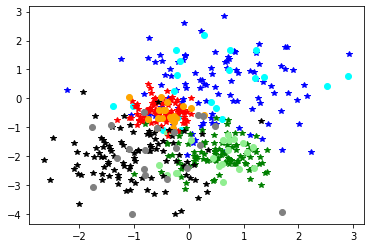

In [43]:
plot_toy_dataset((X_tr, Y_tr), (X_te, Y_te))

In [44]:
X_tr = X_tr.to(dev)
Y_tr = Y_tr.to(dev)
X_te = X_te.to(dev)
Y_te = Y_te.to(dev)

In [45]:
bnn = BBNN_LRGVI(2, 4, prior_logvar=0, hidden_size=[30], alpha=1.25).to(dev)

In [46]:
optimizer = torch.optim.Adam(bnn.parameters(), lr=0.1)

In [47]:
epochs = 2500
beta = 1

In [48]:
bnn_loss = []
bnn_KL = []
bnn_NLL = []
bnn_train_error = []
bnn_test_error = []

In [49]:
# Train loop
t0 = time.time()

for e in range(epochs):

    cum_loss = 0
    cum_KL = 0
    cum_NLL = 0
    cum_acc = 0
    
    
    
    # Train
    bnn.train()
    _loss, _NLL, _KL = bnn.ELBO(X_tr, Y_tr, warm_up=(e<10))

    preds = bnn(X_tr)
    _, _preds = torch.max(preds, dim=1)
    _acc = torch.sum(_preds==Y_tr)

    cum_loss += _loss.item()
    cum_NLL += _NLL.item()
    cum_KL += _KL.item()

    cum_acc += _acc.item()

    optimizer.zero_grad()
    _loss.backward()
    optimizer.step()

            
    # Test
    if e%50 == 0:
        bnn.eval()
        test_acc = 0
        preds = bnn.predictive(X_te, n_samples=100)

        _, _preds = torch.max(preds, dim=1)
        _acc = torch.sum(_preds==Y_te)
        test_acc += _acc.item()

    bnn_loss.append(cum_loss)
    bnn_KL.append(cum_KL)
    bnn_NLL.append(cum_NLL)
    bnn_train_error.append(100.*(cum_acc)/N_tr)
    bnn_test_error.append(100.*(test_acc)/N_te)
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, loss: {:.3e}, NLL: {:.3e}, D: {:.3e}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(
              e, time.time()-t0, bnn_loss[-1], bnn_NLL[-1], bnn_KL[-1], bnn_train_error[-1], bnn_test_error[-1]), end='\r')

In [50]:
bnn.cpu()
bnn.eval()

print('####### POSTERIOR RESULTS ###### \n')

train_probs = bnn.predictive(X_tr.cpu(), n_samples=1000).detach().cpu().numpy()
test_probs = bnn.predictive(X_te.cpu(), n_samples=1000).detach().cpu().numpy()

train_acc = np.mean(np.argmax(train_probs, axis=1)==Y_tr.cpu().numpy())
test_acc = np.mean(np.argmax(test_probs, axis=1)==Y_te.cpu().numpy())

print("Train ACC: {:.2f}".format(train_acc*100))
print("Test ACC: {:.2f}".format(test_acc*100))


train_ece = expected_calibration_error(train_probs, Y_tr.cpu().numpy())
test_ece = expected_calibration_error(test_probs, Y_te.cpu().numpy())

print("Train ECE: {:.3f}".format(train_ece))
print("Test ECE: {:.3f}".format(test_ece))


print('\n\n ####### MAP RESULTS ###### \n')

train_probs = softmax(bnn.MAP(X_tr.cpu()).detach().cpu().numpy(), axis=1)
test_probs = softmax(bnn.MAP(X_te.cpu()).detach().cpu().numpy(), axis=1)

train_acc = np.mean(np.argmax(train_probs, axis=1)==Y_tr.cpu().numpy())
test_acc = np.mean(np.argmax(test_probs, axis=1)==Y_te.cpu().numpy())

print("Train ACC: {:.2f}".format(train_acc*100))
print("Test ACC: {:.2f}".format(test_acc*100))


train_ece = expected_calibration_error(train_probs, Y_tr.cpu().numpy())
test_ece = expected_calibration_error(test_probs, Y_te.cpu().numpy())

print("Train ECE: {:.3f}".format(train_ece))
print("Test ECE: {:.3f}".format(test_ece))

####### POSTERIOR RESULTS ###### 

Train ACC: 84.75
Test ACC: 73.75
Train ECE: 0.044
Test ECE: 0.102


 ####### MAP RESULTS ###### 

Train ACC: 84.25
Test ACC: 73.75
Train ECE: 0.033
Test ECE: 0.149


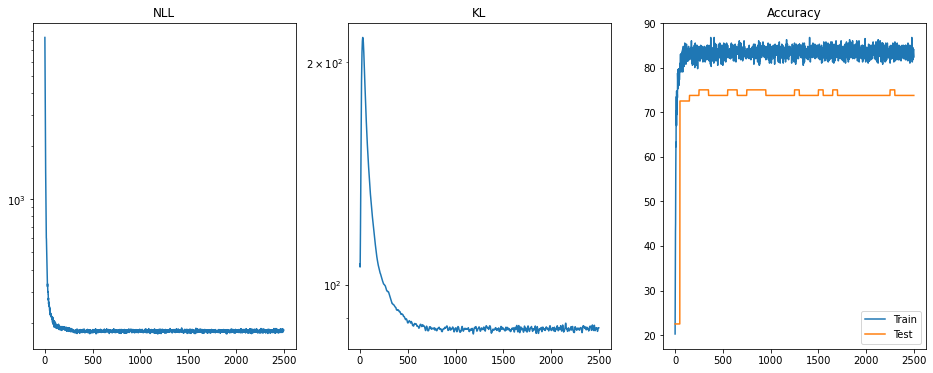

In [51]:
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(bnn_NLL)
ax_arr[0].set_yscale('log')
ax_arr[0].set_title('NLL')


ax_arr[1].plot(bnn_KL)
ax_arr[1].set_yscale('log')
ax_arr[1].set_title('KL')

ax_arr[2].plot(bnn_train_error)
ax_arr[2].plot(bnn_test_error)
ax_arr[2].set_title('Accuracy')
ax_arr[2].legend(['Train', 'Test'])

plt.show()

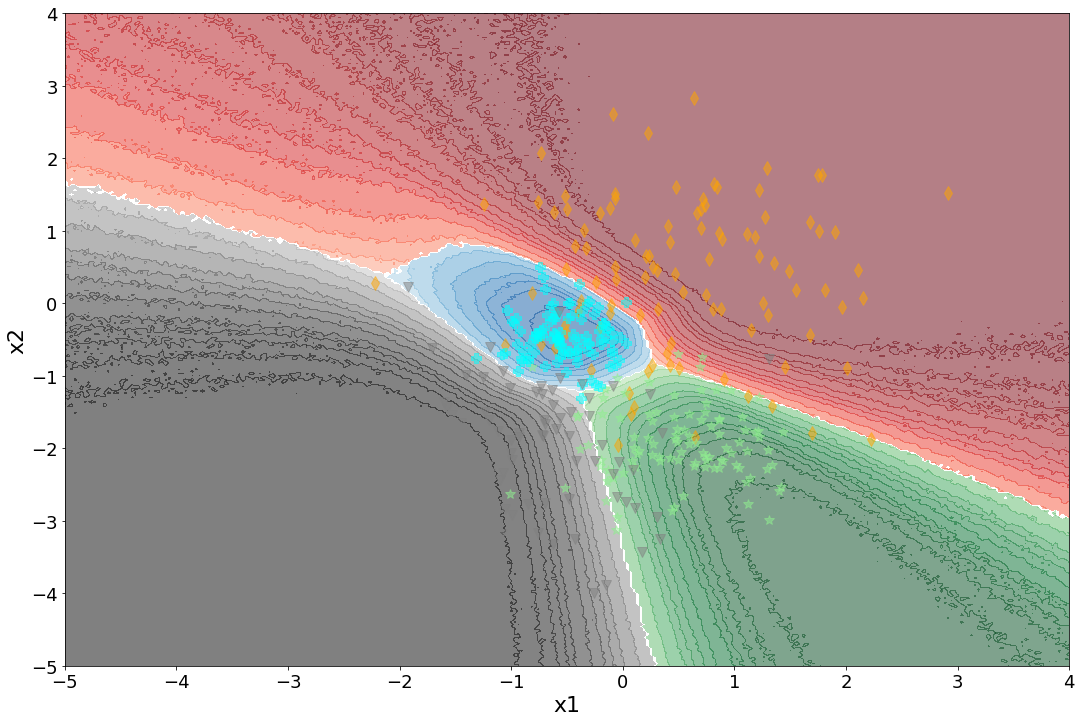

In [52]:
bnn.cpu()
plot_toy_regions((X_tr, Y_tr), (X_te, Y_te), bnn)

## Train Baseline

In [26]:
baseline = nn.Sequential(
        nn.Linear(784, 1200),
        nn.ReLU(),
        nn.Linear(1200, 1200),
        nn.ReLU(),
        nn.Linear(1200, 10),
    ).to(dev)

In [27]:
optimizer = torch.optim.Adam(baseline.parameters())
CE = torch.nn.CrossEntropyLoss(reduction='sum')

In [28]:
baseline_NLL = []
baseline_train_error = []
baseline_test_error = []

In [29]:
# Train loop
t0 = time.time()

for e in range(epochs):

    cum_NLL = 0
    cum_acc = 0
    
    
    # Train
    baseline.train()
    for step, (images, targets) in enumerate(train_loader):
        n = images.shape[0]
        images = images.view(n, -1)
        images = images.to(dev, non_blocking=True)
        targets = targets.to(dev, non_blocking=True)

        preds = baseline(images)
        
        _NLL = CE(preds, targets)
        if _NLL != _NLL:
            print(preds)
            break
        
        _loss = _NLL

        _, _preds = torch.max(preds, dim=1)
        _acc = torch.sum(_preds==targets)
        
        cum_NLL += _NLL.item()
        cum_acc += _acc.item()

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()
        
    if _NLL != _NLL:
            break
            
    # Test
    baseline.eval()
    test_acc = 0
    for step, (images, targets) in enumerate(test_loader):
        n = images.shape[0]
        images = images.view(n, -1)
        images = images.to(dev, non_blocking=True)
        targets = targets.to(dev, non_blocking=True)
        
        preds = baseline(images)
        
        _, _preds = torch.max(preds, dim=1)
        _acc = torch.sum(_preds==targets)
        test_acc += _acc.item()

    baseline_NLL.append(cum_NLL/len(train_mnist_dataset))
    baseline_train_error.append(100. - 100.*(cum_acc/len(train_mnist_dataset)))
    baseline_test_error.append(100. - 100.*(test_acc/len(test_mnist_dataset)))
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, NLL: {:.3e}, Train Error: {:.2f}, Test Error: {:.2f}'.format(
              e, time.time()-t0, baseline_NLL[-1], baseline_train_error[-1], baseline_test_error[-1]), end='\r')

NameError: name 'train_loader' is not defined

In [ ]:
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))

ax_arr[0].plot(baseline_NLL)
ax_arr[0].set_yscale('log')
ax_arr[0].set_title('NLL')


ax_arr[1].plot(baseline_train_error)
ax_arr[1].plot(baseline_test_error)
ax_arr[1].set_title('Error rate')
ax_arr[1].legend(['Train', 'Test'])

plt.show()